In [1]:
!pip3 install folium
!pip3 install pandas
!pip3 install seaborn
!pip3 install pandas-gbq

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [49]:
import pandas as pd 
import folium

from folium import plugins
from folium.plugins import HeatMap

import seaborn as sns 
import matplotlib.pyplot as plt

import numpy as np
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
PROJECT_ID = 'ml-research-playground'

In [4]:
sample_query = """ 
SELECT * 

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`

WHERE RAND() < 100000/(SELECT COUNT(*) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`)
"""

df_sampled = pd.read_gbq(sample_query, project_id=PROJECT_ID, dialect='standard')

# Data exploration



In [5]:
df_sampled.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,99624.000000,100815.000000,6.211100e+04,6.137600e+04,85678.000000,83599.000000,100815.000000,100815.000000,100815.000000,100815.000000,100815.000000,85680.000000,85680.000000,83770.000000,83770.000000
mean,747.747611,2.741919,1.703136e+10,1.703135e+10,22.365730,21.090109,1283.680097,128.349204,0.758359,85.012260,1499.380231,41.902530,-87.657467,41.902457,-87.654550
std,1241.039737,11.926939,3.393837e+05,3.328572e+05,19.371572,17.755794,4693.719369,242.524498,55.449718,1482.474844,5016.574244,0.037358,0.068037,0.038346,0.057979
min,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.663671,-87.913625,41.660136,-87.913625
25%,300.000000,0.000000,1.703108e+10,1.703108e+10,8.000000,8.000000,600.000000,0.000000,0.000000,0.000000,685.000000,41.880994,-87.655998,41.880994,-87.655998
50%,540.000000,0.900000,1.703128e+10,1.703124e+10,11.000000,12.000000,805.000000,0.000000,0.000000,0.000000,945.000000,41.892508,-87.632746,41.893216,-87.633308
75%,900.000000,2.400000,1.703183e+10,1.703183e+10,32.000000,32.000000,1305.000000,200.000000,0.000000,100.000000,1485.000000,41.919225,-87.626211,41.922686,-87.626215
max,86340.000000,2510.000000,1.703198e+10,1.703198e+10,77.000000,77.000000,800168.000000,8319.000000,5000.000000,444446.000000,805188.000000,42.009623,-87.540936,42.021224,-87.534903


In [17]:
# histogram of features
# clean features from outliers

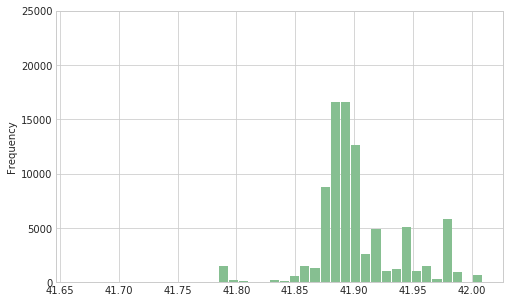

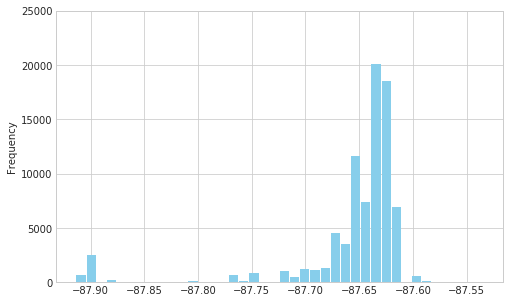

In [42]:
plt.figure(figsize=(8,5))
df_sampled.pickup_latitude.plot(kind='hist', bins=40,color='#86bf91', zorder=2, rwidth=0.9, ylim=(0,25000))
plt.show()

plt.figure(figsize=(8,5))
df_sampled.dropoff_longitude.plot(kind='hist', bins=40,color='skyblue', zorder=2, rwidth=0.9, ylim=(0,25000))
plt.show()

# Date-Time Features

In [6]:
df_sampled['ts'] = df_sampled['trip_start_timestamp'].apply(pd.Timestamp)

In [7]:
df_sampled['weekday'] = df_sampled['ts'].dt.weekday
df_sampled['day'] = df_sampled['ts'].dt.day
df_sampled['month'] = df_sampled['ts'].dt.month
df_sampled['year'] = df_sampled['ts'].dt.year
df_sampled['hour'] = df_sampled['ts'].dt.hour

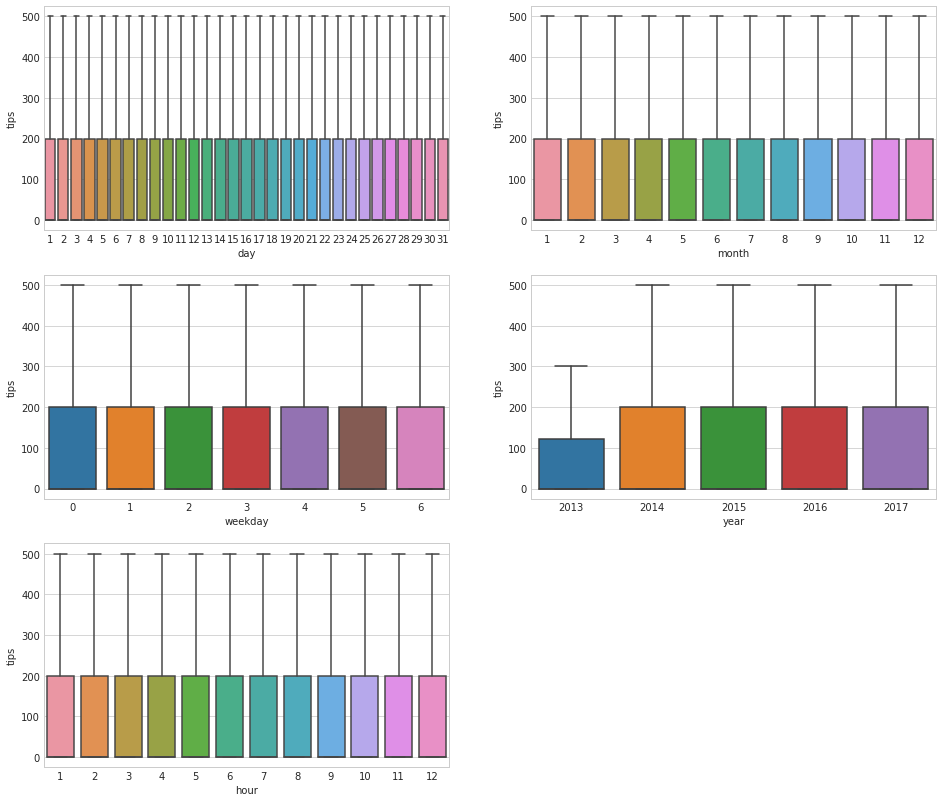

In [8]:
time_features = ['day', 'month', 'weekday', 'year', 'hour']

fig = plt.figure(figsize=(16,14))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(len(time_features)):
    ax = fig.add_subplot(3, 2, i+1)
    sns.boxplot(x=time_features[i], y="tips", data=df_sampled[df_sampled['year'] >= 2013], showfliers=False)

plt.show()

In [9]:
chicago_bounding_box = (-87.9395,-87.5245, 41.6446,  42.0229)

In [10]:
def filter_coordinates(df, box):
    return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <=box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

In [11]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude,c=c[1], s=0.1,  lw=0.1, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


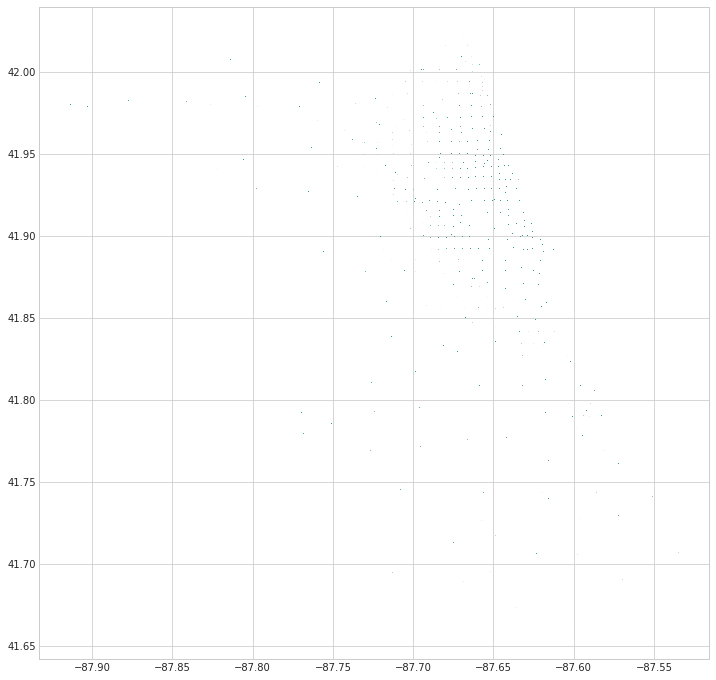

In [12]:
plot_hires(df_sampled, chicago_bounding_box)

In [47]:
chicago_map = folium.Map(location=[41.881832, -87.623177])

In [ ]:
heat_data = [[[df_sampled.pickup_latitude,df_sampled.pickup_longitude] 
                for index, row in df_sampled[df_sampled['month'].astype(float) == i].iterrows()] 
                 for i in range(0,6)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(chicago_map)

# Display the map
chicago_map

# Ride distance

In [13]:
df_sampled['air_distance'] = (df_sampled.pickup_longitude - df_sampled.dropoff_longitude)**2 +\
                     (df_sampled.pickup_latitude - df_sampled.dropoff_latitude)**2
df_sampled['air_distance'] = np.sqrt(df_sampled['air_distance'])

In [14]:
df_sampled['price_per_distance'] = df_sampled['trip_total'] / df_sampled['air_distance']

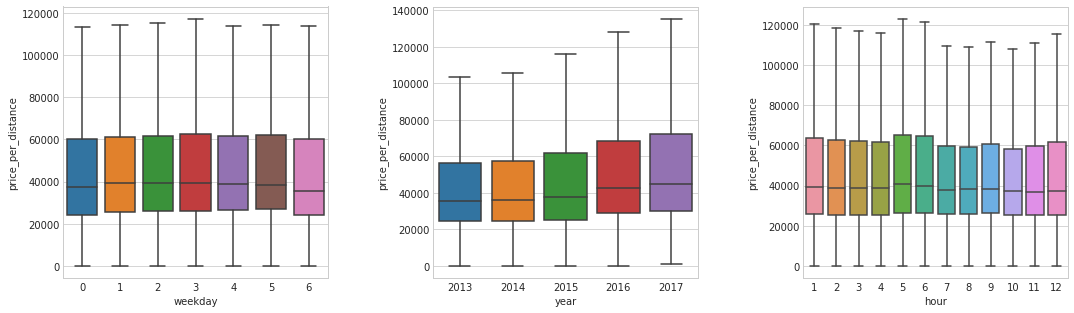

In [15]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="price_per_distance", data=df_sampled[df_sampled['year'] >= 2013], showfliers=False)

plt.show()

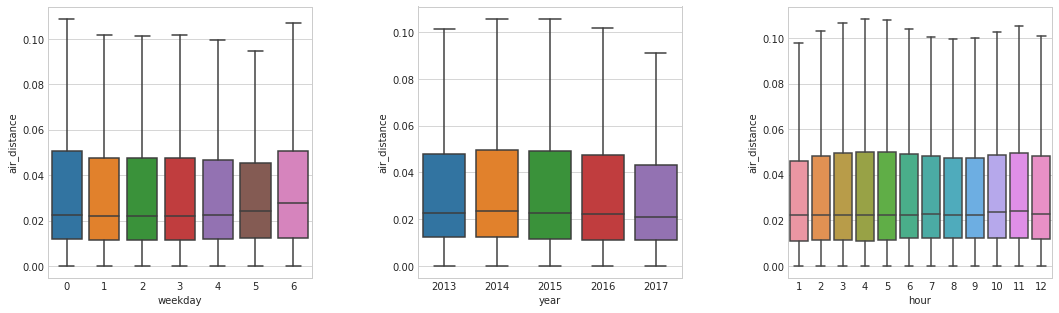

In [16]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="air_distance", data=df_sampled[df_sampled['year'] >= 2013], showfliers=False)

plt.show()

# Tips analysis

In [98]:
df_sampled.sample(6)

,tips
97996,0.0
49051,0.0
17298,0.0
81371,0.0
34973,600.0
1881,0.0


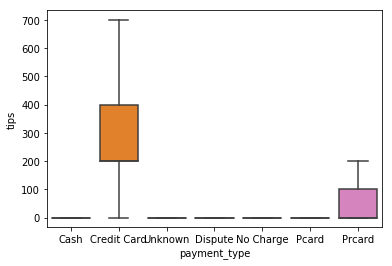

In [93]:
sns.boxplot(data=df_sampled, x='payment_type',y='tips',  showfliers=False)
plt.show()

In [106]:
top_companies = df_sampled.groupby('company')['unique_key'].count().sort_values(ascending=False)[:10].index.tolist()

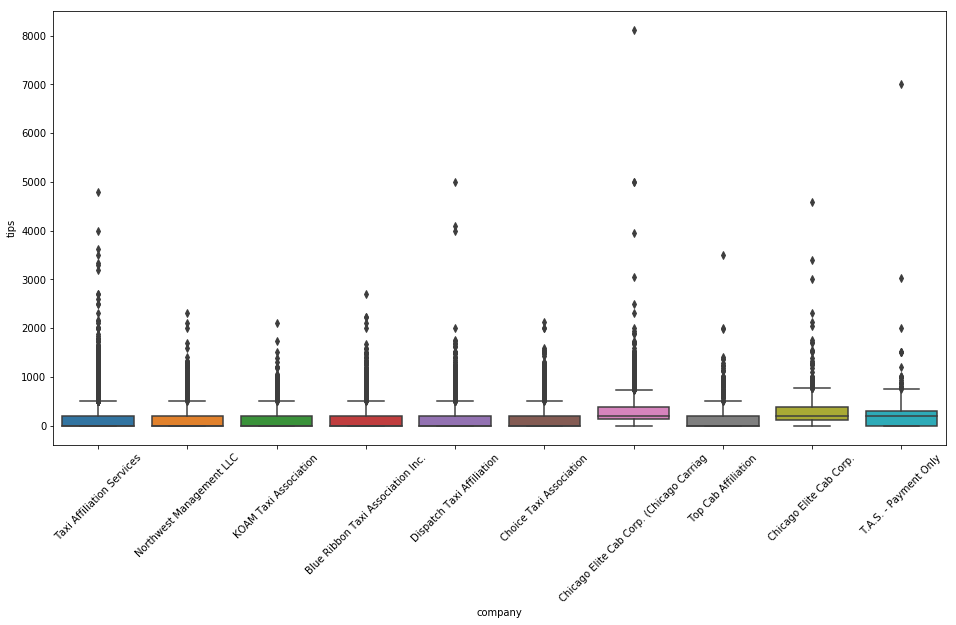

In [109]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_sampled[df_sampled['company'].isin(top_companies)], x='company',y='tips')
plt.xticks(rotation=45)
plt.show()

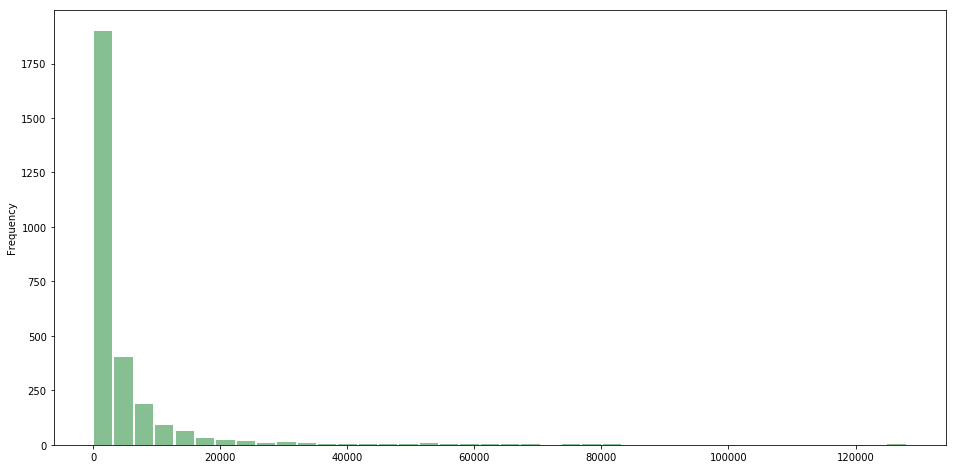

In [60]:
df_sampled.groupby('trip_total')['tips'].sum().plot(kind='hist',x='trip_total',y='tips',figsize=(16,8), bins=40,color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

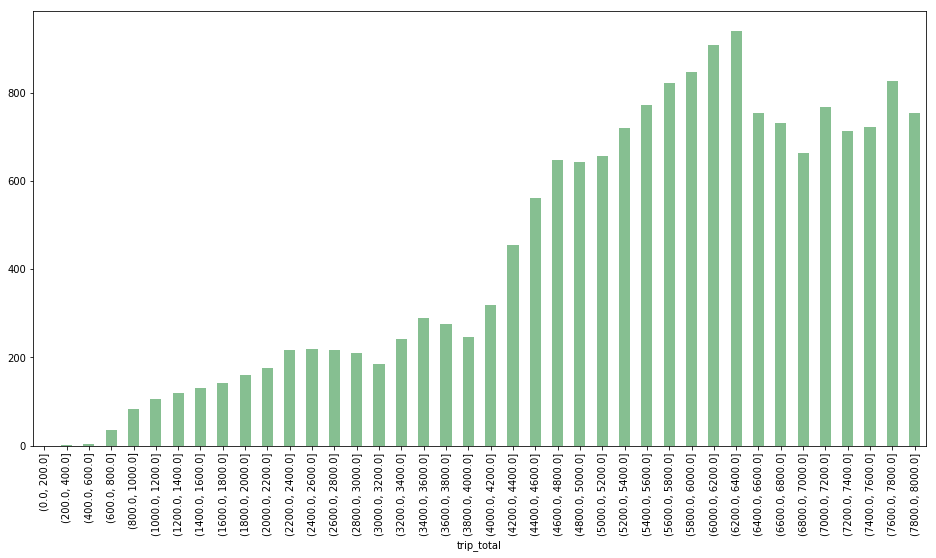

In [87]:
import numpy as np
bins = np.arange(start = 0, stop = df_sampled['tips'].max(), step=200)
df = df_sampled.groupby(pd.cut(df_sampled['trip_total'], bins=bins))['tips'].mean()
df.plot(kind='bar',x='trip_total',y='tips',figsize=(16,8),color='#86bf91')

In [79]:
#folium maps - draw markers no more than 5000

In [ ]:
# scatter plot for lat lon, color by tip
# group by area and calculate average tip per are (round(5))


In [ ]:
# 